In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          20544     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4657 - acc: 0.2251
Epoch 00001: val_loss improved from inf to 2.27238, saving model to model/checkpoint/1D_CNN_1_conv_custom_DO_checkpoint/001-2.2724.hdf5
36805/36805 [==============================] - 28s 765us/sample - loss: 2.4657 - acc: 0.2251 - val_loss: 2.2724 - val_acc: 0.3210
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9935 - acc: 0.4095
Epoch 00002: val_loss improved from 2.27238 to 2.15745, saving model to model/checkpoint/1D_CNN_1_conv_custom_DO_checkpoint/002-2.1574.hdf5
36805/36805 [==============================] - 27s 723us/sample - loss: 1.9935 - acc: 0.4095 - val_loss: 2.1574 - val_acc: 0.3345
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6998 - acc: 0.5042
Epoch 00003: val_loss improved from 2.15745 to 2.13887, saving model to model/c

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9788
Epoch 00029: val_loss did not improve from 2.13887
36805/36805 [==============================] - 26s 710us/sample - loss: 0.1442 - acc: 0.9788 - val_loss: 3.8123 - val_acc: 0.3217
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1377 - acc: 0.9792
Epoch 00030: val_loss did not improve from 2.13887
36805/36805 [==============================] - 26s 710us/sample - loss: 0.1377 - acc: 0.9792 - val_loss: 3.8199 - val_acc: 0.3287
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9802
Epoch 00031: val_loss did not improve from 2.13887
36805/36805 [==============================] - 26s 710us/sample - loss: 0.1313 - acc: 0.9802 - val_loss: 3.8742 - val_acc: 0.3268
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1266 - acc: 0.9818
Epoch 00032: val_loss did not improve from 2.13887
36805/36805 [=====

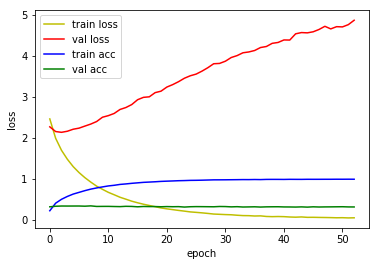

4815/4815 [==============================] - 1s 285us/sample - loss: 2.1425 - acc: 0.3302
Loss: 2.142511772936131 Accuracy: 0.33021808

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2475 - acc: 0.3053
Epoch 00001: val_loss improved from inf to 1.93861, saving model to model/checkpoint/1D_CNN_2_conv_custom_DO_checkpoint/001-1.9386.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 2.2474 - acc: 0.3053 - val_loss: 1.9386 - val_acc: 0.4225
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7677 - acc: 0.4715
Epoch 00002: val_loss improved from 1.93861 to 1.77628, saving model to model/checkpoint/1D_CNN_2_conv_custom_DO_checkpoint/002-1.7763.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 1.7678 - acc: 0.4715 - val_loss: 1.7763 - val_acc: 0.4549
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5122 - acc: 0.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9793
Epoch 00029: val_loss did not improve from 1.74224
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0976 - acc: 0.9793 - val_loss: 3.5272 - val_acc: 0.4475
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0934 - acc: 0.9798
Epoch 00030: val_loss did not improve from 1.74224
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0934 - acc: 0.9798 - val_loss: 3.4463 - val_acc: 0.4493
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0876 - acc: 0.9799
Epoch 00031: val_loss did not improve from 1.74224
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0876 - acc: 0.9799 - val_loss: 3.4871 - val_acc: 0.4423
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9807
Epoch 00032: val_loss did not improve from 1.74224
36805/36805 [===========

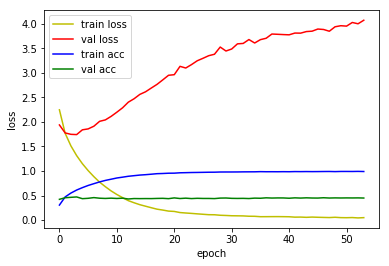

4815/4815 [==============================] - 2s 462us/sample - loss: 1.8242 - acc: 0.4415
Loss: 1.8241748784313816 Accuracy: 0.44153687

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1683 - acc: 0.3198
Epoch 00001: val_loss improved from inf to 1.75137, saving model to model/checkpoint/1D_CNN_3_conv_custom_DO_checkpoint/001-1.7514.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.1684 - acc: 0.3197 - val_loss: 1.7514 - val_acc: 0.4712
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5727 - acc: 0.5167
Epoch 00002: val_loss improved from 1.75137 to 1.52644, saving model to model/checkpoint/1D_CNN_3_conv_custom_DO_checkpoint/002-1.5264.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.5726 - acc: 0.5167 - val_loss: 1.5264 - val_acc: 0.5295
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3368 - acc: 0

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1494 - acc: 0.9573
Epoch 00029: val_loss did not improve from 1.41793
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1494 - acc: 0.9573 - val_loss: 2.2257 - val_acc: 0.5849
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1515 - acc: 0.9552
Epoch 00030: val_loss did not improve from 1.41793
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1515 - acc: 0.9552 - val_loss: 2.2585 - val_acc: 0.5959
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1402 - acc: 0.9605
Epoch 00031: val_loss did not improve from 1.41793
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1402 - acc: 0.9605 - val_loss: 2.2356 - val_acc: 0.5975
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1361 - acc: 0.9613
Epoch 00032: val_loss did not improve from 1.41793
36805/36805 [===========

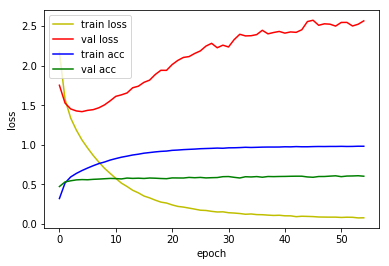

4815/4815 [==============================] - 3s 525us/sample - loss: 1.5022 - acc: 0.5221
Loss: 1.5021918883081042 Accuracy: 0.5221184

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0926 - acc: 0.3283
Epoch 00001: val_loss improved from inf to 1.62085, saving model to model/checkpoint/1D_CNN_4_conv_custom_DO_checkpoint/001-1.6209.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.0925 - acc: 0.3283 - val_loss: 1.6209 - val_acc: 0.4831
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5194 - acc: 0.5224
Epoch 00002: val_loss improved from 1.62085 to 1.38378, saving model to model/checkpoint/1D_CNN_4_conv_custom_DO_checkpoint/002-1.3838.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.5195 - acc: 0.5223 - val_loss: 1.3838 - val_acc: 0.5740
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3175 - acc: 0.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1996 - acc: 0.9366
Epoch 00027: val_loss did not improve from 1.00802
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1996 - acc: 0.9366 - val_loss: 1.2099 - val_acc: 0.7237
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1936 - acc: 0.9384
Epoch 00028: val_loss did not improve from 1.00802
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1935 - acc: 0.9384 - val_loss: 1.2412 - val_acc: 0.7165
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1822 - acc: 0.9432
Epoch 00029: val_loss did not improve from 1.00802
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1822 - acc: 0.9432 - val_loss: 1.2327 - val_acc: 0.7233
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1720 - acc: 0.9456
Epoch 00030: val_loss did not improve from 1.00802
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0937 - acc: 0.9721
Epoch 00057: val_loss did not improve from 1.00802
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0937 - acc: 0.9721 - val_loss: 1.4051 - val_acc: 0.7447
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9726
Epoch 00058: val_loss did not improve from 1.00802
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0892 - acc: 0.9726 - val_loss: 1.4265 - val_acc: 0.7419
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9720
Epoch 00059: val_loss did not improve from 1.00802
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0901 - acc: 0.9720 - val_loss: 1.4500 - val_acc: 0.7393
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0914 - acc: 0.9719
Epoch 00060: val_loss did not improve from 1.00802
36805/36805 [===========

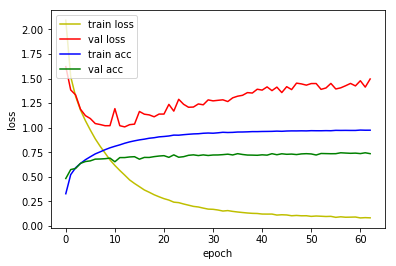

4815/4815 [==============================] - 3s 557us/sample - loss: 1.1312 - acc: 0.6681
Loss: 1.1311824612652153 Accuracy: 0.66812044

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1148 - acc: 0.3087
Epoch 00001: val_loss improved from inf to 1.63786, saving model to model/checkpoint/1D_CNN_5_conv_custom_DO_checkpoint/001-1.6379.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.1148 - acc: 0.3087 - val_loss: 1.6379 - val_acc: 0.4633
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5104 - acc: 0.5204
Epoch 00002: val_loss improved from 1.63786 to 1.32720, saving model to model/checkpoint/1D_CNN_5_conv_custom_DO_checkpoint/002-1.3272.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.5104 - acc: 0.5203 - val_loss: 1.3272 - val_acc: 0.6010
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3013 - acc: 0

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2213 - acc: 0.9289
Epoch 00026: val_loss did not improve from 0.73995
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2213 - acc: 0.9289 - val_loss: 0.8083 - val_acc: 0.7994
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2088 - acc: 0.9336
Epoch 00027: val_loss did not improve from 0.73995
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2088 - acc: 0.9336 - val_loss: 0.8246 - val_acc: 0.7983
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1967 - acc: 0.9369
Epoch 00028: val_loss did not improve from 0.73995
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1966 - acc: 0.9369 - val_loss: 0.8349 - val_acc: 0.8029
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1959 - acc: 0.9371
Epoch 00029: val_loss did not improve from 0.73995
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0874 - acc: 0.9733
Epoch 00056: val_loss did not improve from 0.73995
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0874 - acc: 0.9733 - val_loss: 0.9207 - val_acc: 0.8174
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9730
Epoch 00057: val_loss did not improve from 0.73995
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0885 - acc: 0.9730 - val_loss: 0.9597 - val_acc: 0.8178
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0872 - acc: 0.9737
Epoch 00058: val_loss did not improve from 0.73995
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0872 - acc: 0.9737 - val_loss: 0.9341 - val_acc: 0.8160
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9708
Epoch 00059: val_loss did not improve from 0.73995
36805/36805 [===========

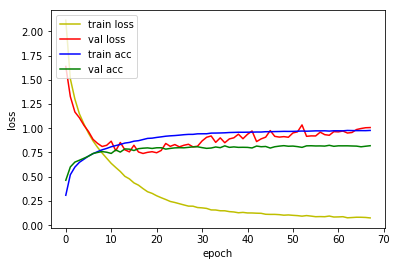

4815/4815 [==============================] - 3s 582us/sample - loss: 0.8501 - acc: 0.7541
Loss: 0.850051138111364 Accuracy: 0.75410175

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1860 - acc: 0.2803
Epoch 00001: val_loss improved from inf to 1.60277, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_checkpoint/001-1.6028.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.1859 - acc: 0.2803 - val_loss: 1.6028 - val_acc: 0.4978
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5582 - acc: 0.4948
Epoch 00002: val_loss improved from 1.60277 to 1.32999, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_checkpoint/002-1.3300.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.5581 - acc: 0.4949 - val_loss: 1.3300 - val_acc: 0.5761
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3583 - acc: 0.

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3248 - acc: 0.9002
Epoch 00025: val_loss did not improve from 0.39566
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3248 - acc: 0.9002 - val_loss: 0.4071 - val_acc: 0.8901
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3101 - acc: 0.9048
Epoch 00026: val_loss did not improve from 0.39566
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3100 - acc: 0.9048 - val_loss: 0.4133 - val_acc: 0.8903
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2955 - acc: 0.9101
Epoch 00027: val_loss improved from 0.39566 to 0.38785, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_checkpoint/027-0.3879.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2955 - acc: 0.9101 - val_loss: 0.3879 - val_acc: 0.8940
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2801 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1315 - acc: 0.9577
Epoch 00053: val_loss did not improve from 0.36620
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1315 - acc: 0.9577 - val_loss: 0.3802 - val_acc: 0.9159
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1252 - acc: 0.9589
Epoch 00054: val_loss did not improve from 0.36620
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1252 - acc: 0.9589 - val_loss: 0.3829 - val_acc: 0.9124
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9604
Epoch 00055: val_loss did not improve from 0.36620
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1199 - acc: 0.9604 - val_loss: 0.3743 - val_acc: 0.9108
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9585
Epoch 00056: val_loss did not improve from 0.36620
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9754
Epoch 00083: val_loss did not improve from 0.36620
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0757 - acc: 0.9754 - val_loss: 0.4293 - val_acc: 0.9159
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0725 - acc: 0.9762
Epoch 00084: val_loss did not improve from 0.36620
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0725 - acc: 0.9762 - val_loss: 0.4221 - val_acc: 0.9166
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9761
Epoch 00085: val_loss did not improve from 0.36620
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0744 - acc: 0.9761 - val_loss: 0.4195 - val_acc: 0.9164
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9772
Epoch 00086: val_loss did not improve from 0.36620
36805/36805 [===========

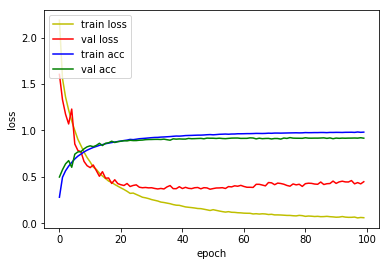

4815/4815 [==============================] - 3s 603us/sample - loss: 0.4367 - acc: 0.8891
Loss: 0.43665088082152115 Accuracy: 0.88909656

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2462 - acc: 0.2586
Epoch 00001: val_loss improved from inf to 1.56702, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_checkpoint/001-1.5670.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.2461 - acc: 0.2587 - val_loss: 1.5670 - val_acc: 0.4987
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5467 - acc: 0.4870
Epoch 00002: val_loss improved from 1.56702 to 1.28698, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_checkpoint/002-1.2870.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.5467 - acc: 0.4870 - val_loss: 1.2870 - val_acc: 0.6040
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3267 - acc: 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2573 - acc: 0.9179
Epoch 00024: val_loss improved from 0.23221 to 0.22142, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_checkpoint/024-0.2214.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2573 - acc: 0.9179 - val_loss: 0.2214 - val_acc: 0.9408
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2461 - acc: 0.9209
Epoch 00025: val_loss did not improve from 0.22142
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2461 - acc: 0.9209 - val_loss: 0.2265 - val_acc: 0.9385
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2430 - acc: 0.9232
Epoch 00026: val_loss improved from 0.22142 to 0.21093, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_checkpoint/026-0.2109.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2430 - acc: 0.9232 - val_loss: 0.2109 - val_acc: 0

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1242 - acc: 0.9583
Epoch 00051: val_loss did not improve from 0.17921
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1242 - acc: 0.9583 - val_loss: 0.1914 - val_acc: 0.9513
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1222 - acc: 0.9592
Epoch 00052: val_loss did not improve from 0.17921
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1222 - acc: 0.9592 - val_loss: 0.1897 - val_acc: 0.9506
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1261 - acc: 0.9585
Epoch 00053: val_loss improved from 0.17921 to 0.17838, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_checkpoint/053-0.1784.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1261 - acc: 0.9585 - val_loss: 0.1784 - val_acc: 0.9548
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1161 

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0750 - acc: 0.9739
Epoch 00080: val_loss did not improve from 0.17024
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0750 - acc: 0.9739 - val_loss: 0.1704 - val_acc: 0.9564
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0778 - acc: 0.9733
Epoch 00081: val_loss improved from 0.17024 to 0.17002, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_checkpoint/081-0.1700.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0778 - acc: 0.9733 - val_loss: 0.1700 - val_acc: 0.9557
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9761
Epoch 00082: val_loss did not improve from 0.17002
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0691 - acc: 0.9761 - val_loss: 0.1854 - val_acc: 0.9571
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0708 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9836
Epoch 00109: val_loss did not improve from 0.17002
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0508 - acc: 0.9836 - val_loss: 0.2089 - val_acc: 0.9576
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9832
Epoch 00110: val_loss did not improve from 0.17002
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0496 - acc: 0.9832 - val_loss: 0.2014 - val_acc: 0.9560
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9837
Epoch 00111: val_loss did not improve from 0.17002
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0480 - acc: 0.9837 - val_loss: 0.1787 - val_acc: 0.9590
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9846
Epoch 00112: val_loss did not improve from 0.17002
36805/36805 [=====================

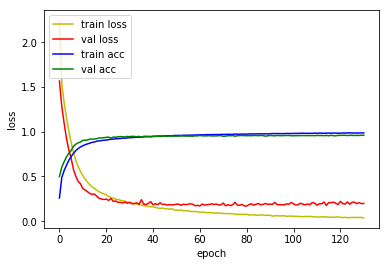

4815/4815 [==============================] - 3s 639us/sample - loss: 0.2075 - acc: 0.9423
Loss: 0.20753561530652942 Accuracy: 0.9422638

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2954 - acc: 0.2514
Epoch 00001: val_loss improved from inf to 1.51844, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_checkpoint/001-1.5184.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.2954 - acc: 0.2514 - val_loss: 1.5184 - val_acc: 0.5451
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4383 - acc: 0.5336
Epoch 00002: val_loss improved from 1.51844 to 0.98173, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_checkpoint/002-0.9817.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4381 - acc: 0.5336 - val_loss: 0.9817 - val_acc: 0.6904
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0850 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.1966 - acc: 0.9365
Epoch 00024: val_loss improved from 0.15045 to 0.14022, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_checkpoint/024-0.1402.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1966 - acc: 0.9365 - val_loss: 0.1402 - val_acc: 0.9585
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1885 - acc: 0.9391
Epoch 00025: val_loss did not improve from 0.14022
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1886 - acc: 0.9391 - val_loss: 0.1549 - val_acc: 0.9532
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1903 - acc: 0.9382
Epoch 00026: val_loss did not improve from 0.14022
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1903 - acc: 0.9382 - val_loss: 0.1878 - val_acc: 0.9397
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1763 - acc: 0.9424

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0864 - acc: 0.9706
Epoch 00052: val_loss improved from 0.11171 to 0.11043, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_checkpoint/052-0.1104.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0864 - acc: 0.9706 - val_loss: 0.1104 - val_acc: 0.9706
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9704
Epoch 00053: val_loss did not improve from 0.11043
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0860 - acc: 0.9704 - val_loss: 0.1147 - val_acc: 0.9679
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9701
Epoch 00054: val_loss did not improve from 0.11043
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0878 - acc: 0.9701 - val_loss: 0.1144 - val_acc: 0.9686
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0834 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9824
Epoch 00081: val_loss did not improve from 0.10763
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0510 - acc: 0.9824 - val_loss: 0.1382 - val_acc: 0.9690
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9834
Epoch 00082: val_loss did not improve from 0.10763
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0483 - acc: 0.9834 - val_loss: 0.1380 - val_acc: 0.9660
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9821
Epoch 00083: val_loss did not improve from 0.10763
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0503 - acc: 0.9821 - val_loss: 0.1208 - val_acc: 0.9686
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9836
Epoch 00084: val_loss did not improve from 0.10763
36805/36805 [========================

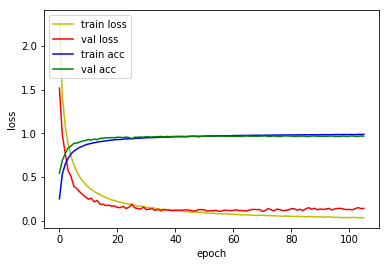

4815/4815 [==============================] - 3s 651us/sample - loss: 0.1726 - acc: 0.9508
Loss: 0.17262063164608255 Accuracy: 0.95077884

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9218 - acc: 0.3786
Epoch 00001: val_loss improved from inf to 1.00127, saving model to model/checkpoint/1D_CNN_9_conv_custom_DO_checkpoint/001-1.0013.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.9218 - acc: 0.3786 - val_loss: 1.0013 - val_acc: 0.6816
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9646 - acc: 0.6920
Epoch 00002: val_loss improved from 1.00127 to 0.64869, saving model to model/checkpoint/1D_CNN_9_conv_custom_DO_checkpoint/002-0.6487.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.9648 - acc: 0.6920 - val_loss: 0.6487 - val_acc: 0.7985
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6981 - acc: 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1059 - acc: 0.9644
Epoch 00026: val_loss did not improve from 0.13357
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1059 - acc: 0.9644 - val_loss: 0.1463 - val_acc: 0.9564
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1020 - acc: 0.9655
Epoch 00027: val_loss did not improve from 0.13357
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1020 - acc: 0.9655 - val_loss: 0.1469 - val_acc: 0.9581
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1009 - acc: 0.9667
Epoch 00028: val_loss did not improve from 0.13357
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1008 - acc: 0.9667 - val_loss: 0.1482 - val_acc: 0.9578
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9676
Epoch 00029: val_loss improved from 0.13357 to 0.13112, saving model to mod

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9875
Epoch 00056: val_loss did not improve from 0.13112
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0403 - acc: 0.9875 - val_loss: 0.1711 - val_acc: 0.9625
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9877
Epoch 00057: val_loss did not improve from 0.13112
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0363 - acc: 0.9877 - val_loss: 0.1679 - val_acc: 0.9637
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9887
Epoch 00058: val_loss did not improve from 0.13112
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0353 - acc: 0.9887 - val_loss: 0.1755 - val_acc: 0.9641
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9882
Epoch 00059: val_loss did not improve from 0.13112
36805/36805 [===========

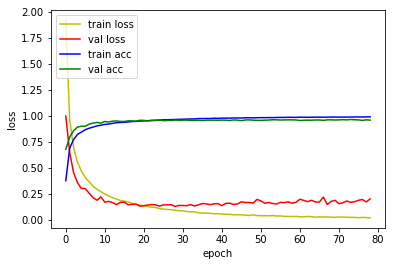

4815/4815 [==============================] - 3s 656us/sample - loss: 0.1936 - acc: 0.9435
Loss: 0.19361841327211937 Accuracy: 0.9435099



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_DO'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 376us/sample - loss: 2.1425 - acc: 0.3302
Loss: 2.142511772936131 Accuracy: 0.33021808

1D_CNN_2_conv_custom_DO Model
_________________________________________________________________

4815/4815 [==============================] - 3s 694us/sample - loss: 0.4367 - acc: 0.8891
Loss: 0.43665088082152115 Accuracy: 0.88909656

1D_CNN_7_conv_custom_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 1777

4815/4815 [==============================] - 4s 747us/sample - loss: 0.1936 - acc: 0.9435
Loss: 0.19361841327211937 Accuracy: 0.9435099


In [12]:
def build_1d_cnn_custom_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [13]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
flatten_18 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 16000, 64)         384       
______________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 5333, 64)          20544     
_________________________________________________________________
batch_normalization_v1_17 (B (None, 5333, 64)          256       
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_36 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_37 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 5333, 64)          20544     
_________________________________________________________________
batch_normalization_v1_38 (B (None, 5333, 64)          256       
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1370 - acc: 0.2636
Epoch 00001: val_loss improved from inf to 2.19535, saving model to model/checkpoint/1D_CNN_1_conv_custom_BN_checkpoint/001-2.1954.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 3.1369 - acc: 0.2636 - val_loss: 2.1954 - val_acc: 0.3119
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2751 - acc: 0.6222
Epoch 00002: val_loss did not improve from 2.19535
36805/36805 [==============================] - 34s 913us/sample - loss: 1.2752 - acc: 0.6222 - val_loss: 2.4531 - val_acc: 0.3198
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7902 - acc: 0.7758
Epoch 00003: val_loss did not improve from 2.19535
36805/36805 [==============================] - 34s 915us/sample - loss: 0.7902 - acc: 0.7758 - val_loss: 2.6584 - val_acc: 0.3380
Epoch 4/500
36800/36805 [============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9955
Epoch 00030: val_loss did not improve from 2.19535
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0402 - acc: 0.9955 - val_loss: 7.0412 - val_acc: 0.2870
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9964
Epoch 00031: val_loss did not improve from 2.19535
36805/36805 [==============================] - 33s 908us/sample - loss: 0.0358 - acc: 0.9964 - val_loss: 6.9153 - val_acc: 0.2895
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9956
Epoch 00032: val_loss did not improve from 2.19535
36805/36805 [==============================] - 33s 908us/sample - loss: 0.0394 - acc: 0.9956 - val_loss: 7.1052 - val_acc: 0.2749
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9926
Epoch 00033: val_loss did not improve from 2.19535
36805/36805 [==================

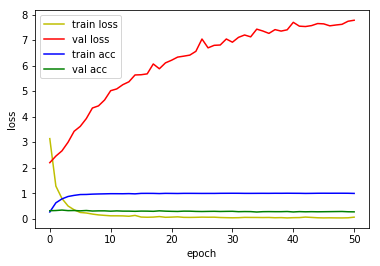

4815/4815 [==============================] - 3s 596us/sample - loss: 2.2578 - acc: 0.2924
Loss: 2.257828987820745 Accuracy: 0.29241952

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.7814 - acc: 0.3395
Epoch 00001: val_loss improved from inf to 9.10648, saving model to model/checkpoint/1D_CNN_2_conv_custom_BN_checkpoint/001-9.1065.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 4.7810 - acc: 0.3395 - val_loss: 9.1065 - val_acc: 0.1591
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9846 - acc: 0.6595
Epoch 00002: val_loss improved from 9.10648 to 4.29445, saving model to model/checkpoint/1D_CNN_2_conv_custom_BN_checkpoint/002-4.2944.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.9854 - acc: 0.6594 - val_loss: 4.2944 - val_acc: 0.3818
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9308 - acc: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.1855 - acc: 0.9812
Epoch 00029: val_loss did not improve from 3.63747
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.1855 - acc: 0.9812 - val_loss: 6.3450 - val_acc: 0.4242
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1751 - acc: 0.9831
Epoch 00030: val_loss did not improve from 3.63747
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.1751 - acc: 0.9831 - val_loss: 6.1166 - val_acc: 0.4307
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1720 - acc: 0.9844
Epoch 00031: val_loss did not improve from 3.63747
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.1720 - acc: 0.9844 - val_loss: 6.3292 - val_acc: 0.4251
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1703 - acc: 0.9846
Epoch 00032: val_loss did not improve from 3.63747
36805/36805 [========================

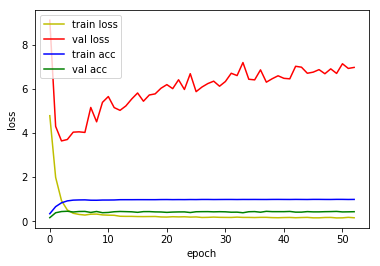

4815/4815 [==============================] - 4s 873us/sample - loss: 3.8510 - acc: 0.4089
Loss: 3.8510181121984624 Accuracy: 0.40893042

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5973 - acc: 0.4182
Epoch 00001: val_loss improved from inf to 8.81868, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_checkpoint/001-8.8187.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.5975 - acc: 0.4181 - val_loss: 8.8187 - val_acc: 0.1465
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1716 - acc: 0.6951
Epoch 00002: val_loss improved from 8.81868 to 2.02389, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_checkpoint/002-2.0239.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 1.1718 - acc: 0.6951 - val_loss: 2.0239 - val_acc: 0.5521
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5699 - acc: 0

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0738 - acc: 0.9871
Epoch 00030: val_loss did not improve from 2.02389
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0738 - acc: 0.9871 - val_loss: 4.5437 - val_acc: 0.5341
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9906
Epoch 00031: val_loss did not improve from 2.02389
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0634 - acc: 0.9905 - val_loss: 4.3719 - val_acc: 0.5441
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0794 - acc: 0.9870
Epoch 00032: val_loss did not improve from 2.02389
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0794 - acc: 0.9870 - val_loss: 4.0907 - val_acc: 0.5719
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9911
Epoch 00033: val_loss did not improve from 2.02389
36805/36805 [===========

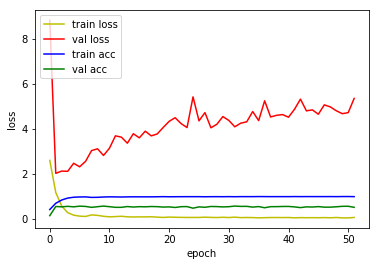

4815/4815 [==============================] - 5s 975us/sample - loss: 2.2918 - acc: 0.5059
Loss: 2.2917579204741543 Accuracy: 0.505919

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9246 - acc: 0.4593
Epoch 00001: val_loss improved from inf to 3.23589, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_checkpoint/001-3.2359.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.9247 - acc: 0.4593 - val_loss: 3.2359 - val_acc: 0.2923
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1271 - acc: 0.6664
Epoch 00002: val_loss improved from 3.23589 to 1.51872, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_checkpoint/002-1.5187.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.1272 - acc: 0.6664 - val_loss: 1.5187 - val_acc: 0.5714
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7936 - acc: 0.7

36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9956
Epoch 00029: val_loss did not improve from 1.32535
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0240 - acc: 0.9956 - val_loss: 2.1787 - val_acc: 0.6713
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9945
Epoch 00030: val_loss did not improve from 1.32535
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0285 - acc: 0.9945 - val_loss: 2.3764 - val_acc: 0.6497
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9957
Epoch 00031: val_loss did not improve from 1.32535
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0249 - acc: 0.9957 - val_loss: 2.5441 - val_acc: 0.6389
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9979
Epoch 00032: val_loss did not improve from 1.32535
36805/36805 [========================

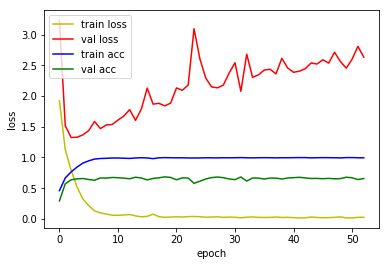

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.4138 - acc: 0.6075
Loss: 1.4138006999856587 Accuracy: 0.60747665

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7018 - acc: 0.5011
Epoch 00001: val_loss improved from inf to 3.27658, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_checkpoint/001-3.2766.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 1.7017 - acc: 0.5012 - val_loss: 3.2766 - val_acc: 0.1982
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0177 - acc: 0.6943
Epoch 00002: val_loss improved from 3.27658 to 1.13373, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_checkpoint/002-1.1337.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.0177 - acc: 0.6943 - val_loss: 1.1337 - val_acc: 0.6730
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7815 - acc: 0.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9960
Epoch 00029: val_loss did not improve from 0.94804
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0230 - acc: 0.9960 - val_loss: 1.4088 - val_acc: 0.7454
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9940
Epoch 00030: val_loss did not improve from 0.94804
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0279 - acc: 0.9940 - val_loss: 1.4736 - val_acc: 0.7501
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9979
Epoch 00031: val_loss did not improve from 0.94804
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0174 - acc: 0.9979 - val_loss: 1.3736 - val_acc: 0.7598
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9965
Epoch 00032: val_loss did not improve from 0.94804
36805/36805 [===========

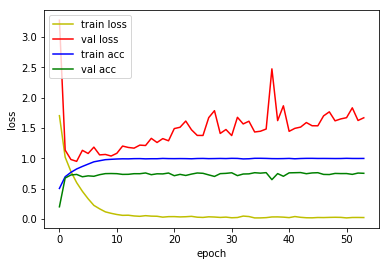

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.0736 - acc: 0.6972
Loss: 1.0735916545705508 Accuracy: 0.69719625

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6149 - acc: 0.5100
Epoch 00001: val_loss improved from inf to 1.78195, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_checkpoint/001-1.7820.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 1.6148 - acc: 0.5100 - val_loss: 1.7820 - val_acc: 0.4291
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9706 - acc: 0.7039
Epoch 00002: val_loss improved from 1.78195 to 1.05231, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_checkpoint/002-1.0523.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.9707 - acc: 0.7039 - val_loss: 1.0523 - val_acc: 0.6837
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7706 - acc: 0.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9979
Epoch 00027: val_loss did not improve from 0.56157
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0167 - acc: 0.9979 - val_loss: 0.6659 - val_acc: 0.8602
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9976
Epoch 00028: val_loss did not improve from 0.56157
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0174 - acc: 0.9975 - val_loss: 0.6621 - val_acc: 0.8621
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9872
Epoch 00029: val_loss did not improve from 0.56157
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0466 - acc: 0.9872 - val_loss: 0.6642 - val_acc: 0.8584
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9974
Epoch 00030: val_loss did not improve from 0.56157
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9982
Epoch 00057: val_loss did not improve from 0.56157
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0109 - acc: 0.9982 - val_loss: 0.7472 - val_acc: 0.8672
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9985
Epoch 00058: val_loss did not improve from 0.56157
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0097 - acc: 0.9985 - val_loss: 0.8711 - val_acc: 0.8535
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9973
Epoch 00059: val_loss did not improve from 0.56157
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0134 - acc: 0.9973 - val_loss: 0.9459 - val_acc: 0.8295
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9936
Epoch 00060: val_loss did not improve from 0.56157
36805/36805 [===========

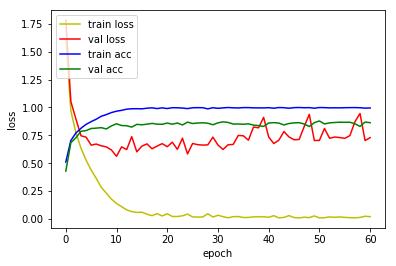

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6433 - acc: 0.8299
Loss: 0.643302805500486 Accuracy: 0.8299065

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6890 - acc: 0.4841
Epoch 00001: val_loss improved from inf to 1.94837, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_checkpoint/001-1.9484.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 1.6891 - acc: 0.4841 - val_loss: 1.9484 - val_acc: 0.3722
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9169 - acc: 0.7265
Epoch 00002: val_loss improved from 1.94837 to 0.81235, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_checkpoint/002-0.8124.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.9170 - acc: 0.7264 - val_loss: 0.8124 - val_acc: 0.7538
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6656 - acc: 0.80

36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9987
Epoch 00027: val_loss improved from 0.32255 to 0.31443, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_checkpoint/027-0.3144.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0107 - acc: 0.9988 - val_loss: 0.3144 - val_acc: 0.9208
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9935
Epoch 00028: val_loss did not improve from 0.31443
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0265 - acc: 0.9935 - val_loss: 0.3733 - val_acc: 0.9080
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9972
Epoch 00029: val_loss did not improve from 0.31443
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0144 - acc: 0.9972 - val_loss: 0.3978 - val_acc: 0.9068
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9962

36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9902
Epoch 00056: val_loss did not improve from 0.30990
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0321 - acc: 0.9901 - val_loss: 0.3623 - val_acc: 0.9187
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9952
Epoch 00057: val_loss did not improve from 0.30990
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0174 - acc: 0.9952 - val_loss: 0.3243 - val_acc: 0.9262
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9994
Epoch 00058: val_loss did not improve from 0.30990
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0044 - acc: 0.9994 - val_loss: 0.3157 - val_acc: 0.9287
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9997
Epoch 00059: val_loss did not improve from 0.30990
36805/36805 [========================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9995
Epoch 00086: val_loss did not improve from 0.30990
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0031 - acc: 0.9995 - val_loss: 0.3693 - val_acc: 0.9283
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9996
Epoch 00087: val_loss did not improve from 0.30990
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0026 - acc: 0.9996 - val_loss: 0.3231 - val_acc: 0.9320
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9994
Epoch 00088: val_loss did not improve from 0.30990
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0027 - acc: 0.9994 - val_loss: 0.4003 - val_acc: 0.9208
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9967
Epoch 00089: val_loss did not improve from 0.30990
36805/36805 [===========

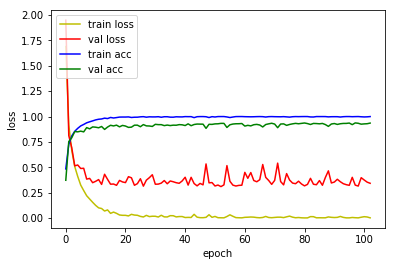

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3666 - acc: 0.9167
Loss: 0.3665670561065524 Accuracy: 0.9167186

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6050 - acc: 0.5191
Epoch 00001: val_loss improved from inf to 1.72197, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_checkpoint/001-1.7220.hdf5
36805/36805 [==============================] - 124s 3ms/sample - loss: 1.6050 - acc: 0.5191 - val_loss: 1.7220 - val_acc: 0.4582
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7245 - acc: 0.7868
Epoch 00002: val_loss improved from 1.72197 to 0.58439, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_checkpoint/002-0.5844.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.7245 - acc: 0.7868 - val_loss: 0.5844 - val_acc: 0.8300
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4781 - acc: 0.8

36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9960
Epoch 00026: val_loss did not improve from 0.19627
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0176 - acc: 0.9960 - val_loss: 0.2014 - val_acc: 0.9490
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9944
Epoch 00027: val_loss did not improve from 0.19627
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0226 - acc: 0.9944 - val_loss: 0.2089 - val_acc: 0.9411
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9981
Epoch 00028: val_loss did not improve from 0.19627
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0104 - acc: 0.9981 - val_loss: 0.2442 - val_acc: 0.9366
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9911
Epoch 00029: val_loss improved from 0.19627 to 0.18201, saving model to model/checkpoint

36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9966
Epoch 00055: val_loss did not improve from 0.18134
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0110 - acc: 0.9966 - val_loss: 0.2349 - val_acc: 0.9406
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9937
Epoch 00056: val_loss did not improve from 0.18134
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0218 - acc: 0.9937 - val_loss: 0.2062 - val_acc: 0.9515
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9990
Epoch 00057: val_loss did not improve from 0.18134
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0047 - acc: 0.9990 - val_loss: 0.1937 - val_acc: 0.9550
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9995
Epoch 00058: val_loss did not improve from 0.18134
36805/36805 [========================

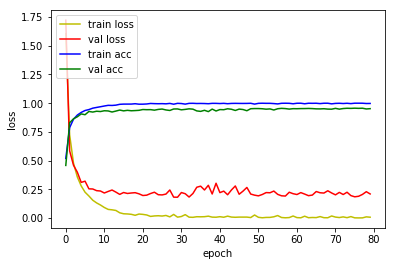

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2526 - acc: 0.9319
Loss: 0.25264046912314614 Accuracy: 0.9318795

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1844 - acc: 0.6386
Epoch 00001: val_loss improved from inf to 1.63275, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_checkpoint/001-1.6327.hdf5
36805/36805 [==============================] - 132s 4ms/sample - loss: 1.1843 - acc: 0.6386 - val_loss: 1.6327 - val_acc: 0.4489
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4632 - acc: 0.8570
Epoch 00002: val_loss improved from 1.63275 to 0.38280, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_checkpoint/002-0.3828.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4632 - acc: 0.8570 - val_loss: 0.3828 - val_acc: 0.8819
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3088 - acc: 0.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9978
Epoch 00027: val_loss did not improve from 0.18427
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0104 - acc: 0.9978 - val_loss: 0.2096 - val_acc: 0.9527
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9952
Epoch 00028: val_loss did not improve from 0.18427
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0180 - acc: 0.9952 - val_loss: 0.2613 - val_acc: 0.9338
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9899
Epoch 00029: val_loss improved from 0.18427 to 0.18212, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_checkpoint/029-0.1821.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0315 - acc: 0.9899 - val_loss: 0.1821 - val_acc: 0.9509
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9976
Epoch 00057: val_loss did not improve from 0.18212
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0084 - acc: 0.9976 - val_loss: 0.2245 - val_acc: 0.9506
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9995
Epoch 00058: val_loss did not improve from 0.18212
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0025 - acc: 0.9995 - val_loss: 0.1990 - val_acc: 0.9595
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9993
Epoch 00059: val_loss did not improve from 0.18212
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0033 - acc: 0.9993 - val_loss: 0.2416 - val_acc: 0.9485
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9990
Epoch 00060: val_loss did not improve from 0.18212
36805/36805 [===========

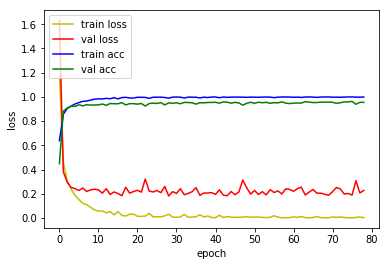

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2790 - acc: 0.9296
Loss: 0.27902466264453757 Accuracy: 0.929595



In [14]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_135 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
flatten_27 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_________________________________________________________________
4815/4815 [==============================] - 4s 818us/sample - loss: 2.2578 - acc: 0.2924
Loss: 2.257828987820745 Accuracy: 0.29241952

1D_CNN_2_conv_custom_BN Model
_______________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.0736 - acc: 0.6972
Loss: 1.0735916545705508 Accuracy: 0.69719625

1D_CNN_6_conv_custom_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 5333, 6

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2526 - acc: 0.9319
Loss: 0.25264046912314614 Accuracy: 0.9318795

1D_CNN_9_conv_custom_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_171 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_82 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 5333, 6

In [16]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [17]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_180 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
flatten_36 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024000)           0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_195 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_105 ( (None, 16000, 64)         256       
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_106 ( (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_154 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 5333, 64)          20544     
_________________________________________________________________
batch_normalization_v1_107 ( (None, 5333, 64)          256       
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_216 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_126 ( (None, 16000, 64)         256       
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_127 ( (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_172 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 5333, 64)          20544     
_________________________________________________________________
batch_normalization_v1_128 ( (None, 5333, 64)          256       
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1190 - acc: 0.2534
Epoch 00001: val_loss improved from inf to 2.18058, saving model to model/checkpoint/1D_CNN_1_conv_custom_DO_BN_checkpoint/001-2.1806.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 3.1189 - acc: 0.2534 - val_loss: 2.1806 - val_acc: 0.3431
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3919 - acc: 0.5826
Epoch 00002: val_loss did not improve from 2.18058
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.3923 - acc: 0.5826 - val_loss: 2.2484 - val_acc: 0.3364
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9292 - acc: 0.7305
Epoch 00003: val_loss did not improve from 2.18058
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.9293 - acc: 0.7305 - val_loss: 2.5850 - val_acc: 0.3028
Epoch 4/500
36800/36805 [=============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9908
Epoch 00030: val_loss did not improve from 2.18058
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0476 - acc: 0.9908 - val_loss: 6.3780 - val_acc: 0.2926
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9923
Epoch 00031: val_loss did not improve from 2.18058
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0420 - acc: 0.9923 - val_loss: 6.3707 - val_acc: 0.3019
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9914
Epoch 00032: val_loss did not improve from 2.18058
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0448 - acc: 0.9914 - val_loss: 6.4284 - val_acc: 0.2933
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9912
Epoch 00033: val_loss did not improve from 2.18058
36805/36805 [========================

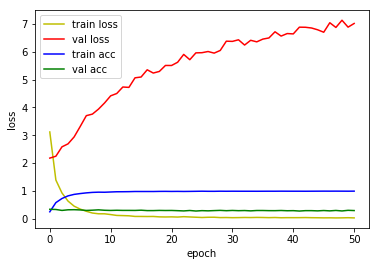

4815/4815 [==============================] - 4s 922us/sample - loss: 2.2086 - acc: 0.3196
Loss: 2.208563860579319 Accuracy: 0.31962618

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.6863 - acc: 0.3068
Epoch 00001: val_loss improved from inf to 6.57003, saving model to model/checkpoint/1D_CNN_2_conv_custom_DO_BN_checkpoint/001-6.5700.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 4.6860 - acc: 0.3069 - val_loss: 6.5700 - val_acc: 0.2080
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5281 - acc: 0.5720
Epoch 00002: val_loss improved from 6.57003 to 3.84712, saving model to model/checkpoint/1D_CNN_2_conv_custom_DO_BN_checkpoint/002-3.8471.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 2.5278 - acc: 0.5720 - val_loss: 3.8471 - val_acc: 0.4253
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5359 - 

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2566 - acc: 0.9676
Epoch 00030: val_loss did not improve from 3.84712
36805/36805 [==============================] - 70s 2ms/sample - loss: 0.2566 - acc: 0.9676 - val_loss: 5.9608 - val_acc: 0.4540
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2605 - acc: 0.9673
Epoch 00031: val_loss did not improve from 3.84712
36805/36805 [==============================] - 70s 2ms/sample - loss: 0.2604 - acc: 0.9673 - val_loss: 6.0595 - val_acc: 0.4451
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2563 - acc: 0.9689
Epoch 00032: val_loss did not improve from 3.84712
36805/36805 [==============================] - 70s 2ms/sample - loss: 0.2563 - acc: 0.9689 - val_loss: 5.9398 - val_acc: 0.4743
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2591 - acc: 0.9685
Epoch 00033: val_loss did not improve from 3.84712
36805/36805 [===========

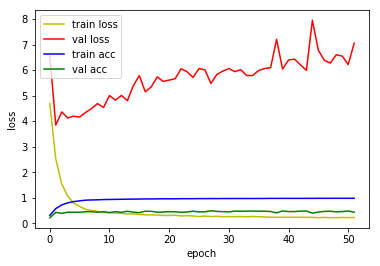

4815/4815 [==============================] - 6s 1ms/sample - loss: 4.1817 - acc: 0.3902
Loss: 4.18169649783696 Accuracy: 0.39023885

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1279 - acc: 0.3634
Epoch 00001: val_loss improved from inf to 5.81144, saving model to model/checkpoint/1D_CNN_3_conv_custom_DO_BN_checkpoint/001-5.8114.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 3.1280 - acc: 0.3634 - val_loss: 5.8114 - val_acc: 0.2066
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8388 - acc: 0.5780
Epoch 00002: val_loss improved from 5.81144 to 1.90102, saving model to model/checkpoint/1D_CNN_3_conv_custom_DO_BN_checkpoint/002-1.9010.hdf5
36805/36805 [==============================] - 79s 2ms/sample - loss: 1.8387 - acc: 0.5780 - val_loss: 1.9010 - val_acc: 0.5679
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2754 - acc

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1716 - acc: 0.9656
Epoch 00030: val_loss did not improve from 1.90102
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1716 - acc: 0.9656 - val_loss: 3.1813 - val_acc: 0.6389
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1612 - acc: 0.9683
Epoch 00031: val_loss did not improve from 1.90102
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1612 - acc: 0.9683 - val_loss: 4.3649 - val_acc: 0.5539
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1714 - acc: 0.9679
Epoch 00032: val_loss did not improve from 1.90102
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1714 - acc: 0.9679 - val_loss: 3.4471 - val_acc: 0.6217
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1543 - acc: 0.9693
Epoch 00033: val_loss did not improve from 1.90102
36805/36805 [===========

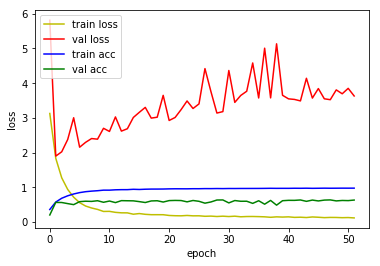

4815/4815 [==============================] - 6s 1ms/sample - loss: 2.0471 - acc: 0.5346
Loss: 2.0471477289932665 Accuracy: 0.53457946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6247 - acc: 0.3750
Epoch 00001: val_loss improved from inf to 3.56659, saving model to model/checkpoint/1D_CNN_4_conv_custom_DO_BN_checkpoint/001-3.5666.hdf5
36805/36805 [==============================] - 126s 3ms/sample - loss: 2.6246 - acc: 0.3750 - val_loss: 3.5666 - val_acc: 0.2516
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6850 - acc: 0.5518
Epoch 00002: val_loss improved from 3.56659 to 1.41129, saving model to model/checkpoint/1D_CNN_4_conv_custom_DO_BN_checkpoint/002-1.4113.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.6852 - acc: 0.5517 - val_loss: 1.4113 - val_acc: 0.5942
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3481 - a

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1516 - acc: 0.9567
Epoch 00029: val_loss did not improve from 1.11476
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1516 - acc: 0.9567 - val_loss: 1.4832 - val_acc: 0.7345
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1511 - acc: 0.9569
Epoch 00030: val_loss did not improve from 1.11476
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1511 - acc: 0.9569 - val_loss: 1.4805 - val_acc: 0.7501
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1497 - acc: 0.9576
Epoch 00031: val_loss did not improve from 1.11476
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1497 - acc: 0.9576 - val_loss: 1.4576 - val_acc: 0.7582
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1492 - acc: 0.9567
Epoch 00032: val_loss did not improve from 1.11476
36805/36805 [===========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1022 - acc: 0.9734
Epoch 00059: val_loss did not improve from 1.11476
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1022 - acc: 0.9734 - val_loss: 1.6039 - val_acc: 0.7727

1D_CNN_4_conv_custom_DO_BN Model


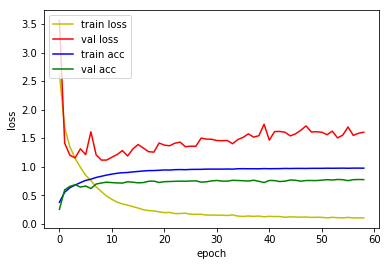

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.2861 - acc: 0.6827
Loss: 1.2860960777427302 Accuracy: 0.6826584

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5633 - acc: 0.3840
Epoch 00001: val_loss improved from inf to 2.89653, saving model to model/checkpoint/1D_CNN_5_conv_custom_DO_BN_checkpoint/001-2.8965.hdf5
36805/36805 [==============================] - 136s 4ms/sample - loss: 2.5631 - acc: 0.3841 - val_loss: 2.8965 - val_acc: 0.2954
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5811 - acc: 0.5764
Epoch 00002: val_loss improved from 2.89653 to 1.20148, saving model to model/checkpoint/1D_CNN_5_conv_custom_DO_BN_checkpoint/002-1.2015.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.5813 - acc: 0.5764 - val_loss: 1.2015 - val_acc: 0.6692
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2757 - ac

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1431 - acc: 0.9567
Epoch 00029: val_loss did not improve from 0.81066
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1430 - acc: 0.9567 - val_loss: 1.0318 - val_acc: 0.7978
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9564
Epoch 00030: val_loss did not improve from 0.81066
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1480 - acc: 0.9564 - val_loss: 0.9834 - val_acc: 0.8188
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1449 - acc: 0.9563
Epoch 00031: val_loss did not improve from 0.81066
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1449 - acc: 0.9562 - val_loss: 2.2716 - val_acc: 0.6935
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1329 - acc: 0.9595
Epoch 00032: val_loss did not improve from 0.81066
36805/36805 [===========


1D_CNN_5_conv_custom_DO_BN Model


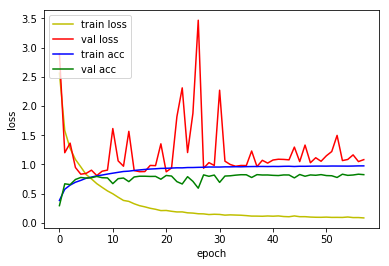

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.8933 - acc: 0.7566
Loss: 0.8932866976516145 Accuracy: 0.756594

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4725 - acc: 0.3592
Epoch 00001: val_loss improved from inf to 2.15240, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_BN_checkpoint/001-2.1524.hdf5
36805/36805 [==============================] - 145s 4ms/sample - loss: 2.4724 - acc: 0.3592 - val_loss: 2.1524 - val_acc: 0.3769
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5190 - acc: 0.5614
Epoch 00002: val_loss improved from 2.15240 to 1.25913, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_BN_checkpoint/002-1.2591.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.5191 - acc: 0.5614 - val_loss: 1.2591 - val_acc: 0.6203
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2194 - acc

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1640 - acc: 0.9470
Epoch 00025: val_loss did not improve from 0.39368
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1640 - acc: 0.9470 - val_loss: 0.4196 - val_acc: 0.8998
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1495 - acc: 0.9527
Epoch 00026: val_loss did not improve from 0.39368
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1495 - acc: 0.9527 - val_loss: 0.4253 - val_acc: 0.8926
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1433 - acc: 0.9541
Epoch 00027: val_loss improved from 0.39368 to 0.38969, saving model to model/checkpoint/1D_CNN_6_conv_custom_DO_BN_checkpoint/027-0.3897.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1433 - acc: 0.9541 - val_loss: 0.3897 - val_acc: 0.9113
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.14

36800/36805 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9813
Epoch 00054: val_loss did not improve from 0.38844
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0601 - acc: 0.9813 - val_loss: 0.4756 - val_acc: 0.9113
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9799
Epoch 00055: val_loss did not improve from 0.38844
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0633 - acc: 0.9799 - val_loss: 0.4640 - val_acc: 0.9152
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9806
Epoch 00056: val_loss did not improve from 0.38844
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0611 - acc: 0.9806 - val_loss: 0.4594 - val_acc: 0.9117
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9811
Epoch 00057: val_loss did not improve from 0.38844
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9869
Epoch 00084: val_loss did not improve from 0.38844
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0414 - acc: 0.9868 - val_loss: 0.4461 - val_acc: 0.9185
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9839
Epoch 00085: val_loss did not improve from 0.38844
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0514 - acc: 0.9839 - val_loss: 0.4692 - val_acc: 0.9175
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9881
Epoch 00086: val_loss did not improve from 0.38844
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0375 - acc: 0.9881 - val_loss: 0.4384 - val_acc: 0.9220
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9851
Epoch 00087: val_loss did not improve from 0.38844
36805/36805 [===========

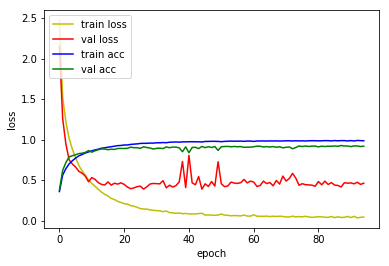

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.4769 - acc: 0.8885
Loss: 0.4769404814374534 Accuracy: 0.8884735

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7139 - acc: 0.2959
Epoch 00001: val_loss improved from inf to 2.23948, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_BN_checkpoint/001-2.2395.hdf5
36805/36805 [==============================] - 154s 4ms/sample - loss: 2.7138 - acc: 0.2959 - val_loss: 2.2395 - val_acc: 0.3044
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6187 - acc: 0.5190
Epoch 00002: val_loss improved from 2.23948 to 0.96190, saving model to model/checkpoint/1D_CNN_7_conv_custom_DO_BN_checkpoint/002-0.9619.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.6186 - acc: 0.5191 - val_loss: 0.9619 - val_acc: 0.7098
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1922 - ac

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1218 - acc: 0.9604
Epoch 00026: val_loss did not improve from 0.21876
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1218 - acc: 0.9604 - val_loss: 0.2498 - val_acc: 0.9329
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1104 - acc: 0.9638
Epoch 00027: val_loss did not improve from 0.21876
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1104 - acc: 0.9637 - val_loss: 0.2622 - val_acc: 0.9306
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9624
Epoch 00028: val_loss did not improve from 0.21876
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1121 - acc: 0.9623 - val_loss: 0.2944 - val_acc: 0.9231
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9669
Epoch 00029: val_loss did not improve from 0.21876
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9867
Epoch 00055: val_loss did not improve from 0.20507
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0423 - acc: 0.9867 - val_loss: 0.2311 - val_acc: 0.9455
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9887
Epoch 00056: val_loss did not improve from 0.20507
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0356 - acc: 0.9887 - val_loss: 0.2574 - val_acc: 0.9434
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9869
Epoch 00057: val_loss did not improve from 0.20507
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0385 - acc: 0.9869 - val_loss: 0.2340 - val_acc: 0.9485
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9836
Epoch 00058: val_loss did not improve from 0.20507
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9894
Epoch 00085: val_loss did not improve from 0.20507
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0322 - acc: 0.9894 - val_loss: 0.2374 - val_acc: 0.9497
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9916
Epoch 00086: val_loss did not improve from 0.20507
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0254 - acc: 0.9916 - val_loss: 0.2797 - val_acc: 0.9420
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9911
Epoch 00087: val_loss did not improve from 0.20507
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0274 - acc: 0.9911 - val_loss: 0.2577 - val_acc: 0.9462

1D_CNN_7_conv_custom_DO_BN Model


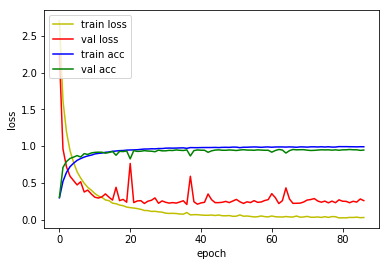

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2529 - acc: 0.9323
Loss: 0.25285784831485275 Accuracy: 0.9322949

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5674 - acc: 0.3429
Epoch 00001: val_loss improved from inf to 2.24616, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/001-2.2462.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 2.5675 - acc: 0.3428 - val_loss: 2.2462 - val_acc: 0.2989
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3626 - acc: 0.5867
Epoch 00002: val_loss improved from 2.24616 to 0.73955, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/002-0.7396.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.3626 - acc: 0.5867 - val_loss: 0.7396 - val_acc: 0.7766
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9700 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9713
Epoch 00025: val_loss improved from 0.16075 to 0.15597, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/025-0.1560.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0902 - acc: 0.9712 - val_loss: 0.1560 - val_acc: 0.9536
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0968 - acc: 0.9682
Epoch 00026: val_loss improved from 0.15597 to 0.15564, saving model to model/checkpoint/1D_CNN_8_conv_custom_DO_BN_checkpoint/026-0.1556.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0968 - acc: 0.9682 - val_loss: 0.1556 - val_acc: 0.9557
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9742
Epoch 00027: val_loss did not improve from 0.15564
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0810 - acc: 0.9742 - val_loss: 0.1628 - val_acc: 0.9520
E

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9914
Epoch 00054: val_loss did not improve from 0.15228
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0279 - acc: 0.9914 - val_loss: 0.1846 - val_acc: 0.9555
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9881
Epoch 00055: val_loss did not improve from 0.15228
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0370 - acc: 0.9881 - val_loss: 0.1856 - val_acc: 0.9539
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9912
Epoch 00056: val_loss did not improve from 0.15228
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0269 - acc: 0.9913 - val_loss: 0.2030 - val_acc: 0.9560
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9931
Epoch 00057: val_loss did not improve from 0.15228
36805/36805 [===========

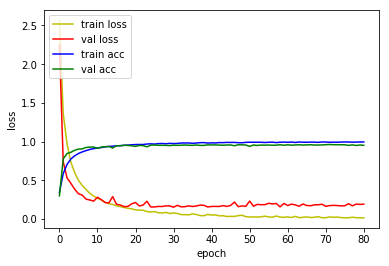

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2036 - acc: 0.9418
Loss: 0.20358542817280176 Accuracy: 0.9418484

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1220 - acc: 0.4524
Epoch 00001: val_loss improved from inf to 1.50660, saving model to model/checkpoint/1D_CNN_9_conv_custom_DO_BN_checkpoint/001-1.5066.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 2.1223 - acc: 0.4524 - val_loss: 1.5066 - val_acc: 0.5215
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9358 - acc: 0.7217
Epoch 00002: val_loss improved from 1.50660 to 0.47111, saving model to model/checkpoint/1D_CNN_9_conv_custom_DO_BN_checkpoint/002-0.4711.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.9357 - acc: 0.7217 - val_loss: 0.4711 - val_acc: 0.8537
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6153 - a

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9832
Epoch 00027: val_loss did not improve from 0.14321
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0510 - acc: 0.9832 - val_loss: 0.1707 - val_acc: 0.9571
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9890
Epoch 00028: val_loss did not improve from 0.14321
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0360 - acc: 0.9891 - val_loss: 0.1567 - val_acc: 0.9588
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9886
Epoch 00029: val_loss did not improve from 0.14321
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0365 - acc: 0.9886 - val_loss: 0.1661 - val_acc: 0.9557
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9897
Epoch 00030: val_loss did not improve from 0.14321
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9931
Epoch 00056: val_loss did not improve from 0.13548
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0234 - acc: 0.9931 - val_loss: 0.1482 - val_acc: 0.9667
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9962
Epoch 00057: val_loss did not improve from 0.13548
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0129 - acc: 0.9962 - val_loss: 0.1502 - val_acc: 0.9669
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9976
Epoch 00058: val_loss did not improve from 0.13548
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0094 - acc: 0.9975 - val_loss: 0.1770 - val_acc: 0.9623
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9912
Epoch 00059: val_loss did not improve from 0.13548
36805/36805 [========================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9946
Epoch 00086: val_loss did not improve from 0.13548
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0165 - acc: 0.9946 - val_loss: 0.1651 - val_acc: 0.9641
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9970
Epoch 00087: val_loss did not improve from 0.13548
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0091 - acc: 0.9970 - val_loss: 0.1508 - val_acc: 0.9651
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9982
Epoch 00088: val_loss did not improve from 0.13548
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0063 - acc: 0.9982 - val_loss: 0.1629 - val_acc: 0.9646
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9978
Epoch 00089: val_loss did not improve from 0.13548
36805/36805 [===========

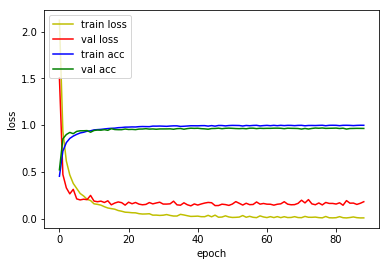

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2021 - acc: 0.9491
Loss: 0.20210764918820634 Accuracy: 0.94911736



In [18]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_DO_BN'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_225 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_135 ( (None, 16000, 64)         256       
_________________________________________________________________
flatten_45 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024000)           0         
_________________________________________________________________
dense_45 (Dense)             (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_________________________________________________________________
4815/4815 [==============================] - 6s 1ms/sample - loss: 2.2086 - acc: 0.3196
Loss: 

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.8933 - acc: 0.7566
Loss: 0.8932866976516145 Accuracy: 0.756594

1D_CNN_6_conv_custom_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_150 ( (None, 16000, 64)         256       
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_151 ( (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_190 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_242 (Conv1D)          (None, 5333, 

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2036 - acc: 0.9418
Loss: 0.20358542817280176 Accuracy: 0.9418484

1D_CNN_9_conv_custom_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_261 (Conv1D)          (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_171 ( (None, 16000, 64)         256       
_________________________________________________________________
conv1d_262 (Conv1D)          (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_172 ( (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_208 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 5333